In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [230]:
TD = date.today() 
TD_str = str(TD)
today = '/'.join([TD_str[8:10], TD_str[5:7], TD_str[2:4]])
LD = date.today() - timedelta(days = 5)
LD_str = str(LD)
last_day = '/'.join([LD_str[8:10], LD_str[5:7], LD_str[2:4]])
today,last_day

('01/04/24', '27/03/24')

In [2]:
import sys
sys.path.append("C:\\Users\\KlimovaAnnaA\\Documents\\MyFiles\\Projects\\OCP")
from Defs import merge_SalesUnits
from Defs import merge_Mapping
from Defs import Period
from Defs import new_list
from Defs import export_from_RISKCUSTOM
from Defs import add_in_currency_column

Cash:

In [17]:
query = """
SELECT "holding", SUM("balanceUsd") AS "cash", "reportDate"
FROM "RISKACCESS"."bankAccountsBalanceDaily"
WHERE "accountStatus" = 'active' AND "bankCountryCode" = 'RU' 
AND "reportDate" >= trunc(sysdate - interval '3' month)
GROUP BY "holding", "reportDate"
ORDER BY "reportDate"
"""

data_cash = export_from_RISKCUSTOM(query)
data_cash = data_cash.sort_values(['reportDate', 'holding']).reset_index(drop=True)
data_cash.tail(6)

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


,holding,cash,reportDate
109,SUEK,3.833431e+07,2024-03-27
110,EUROCHEM,5.143964e+07,2024-03-28
111,SUEK,3.427343e+07,2024-03-28
112,SUEK,1.975150e+07,2024-03-29
113,EUROCHEM,6.379268e+07,2024-03-31
114,SUEK,1.664102e+07,2024-03-31


In [18]:
query = """
SELECT "companyCode" AS "holding", SUM("bookValuePositionCurrency") AS "pre_overdraft", "reportDate"
FROM "RISKACCESS"."sapPositionArrears"
WHERE "productType" = 130 AND "companyCode" IN ('1100', 'E200') 
AND "reportDate" >= trunc(sysdate - interval '3' month) AND "reportDate" <= (SELECT MAX("reportDate") FROM "RISKACCESS"."bankAccountsBalanceDaily")
GROUP BY "companyCode", "reportDate"
ORDER BY "reportDate"
"""

data_overdraft = export_from_RISKCUSTOM(query) # выгрузка запроса
data_overdraft.holding = data_overdraft.holding.replace({'1100': 'SUEK', 'E200':'EUROCHEM'}) # Переименовывание holding
holding_df = pd.DataFrame({'reportDate': data_overdraft.reportDate.unique().tolist(), 'hol1':'SUEK', 'hol2':'EUROCHEM'}) # Добавление каждого holding на каждую из дат выгрузки
holding_df = holding_df.melt(id_vars='reportDate', value_vars=['hol1', 'hol2'], value_name='holding').drop(columns='variable')
data_overdraft = data_overdraft.merge(holding_df, how='right')
limit_df = pd.DataFrame({'holding': ['SUEK', 'EUROCHEM'], 'limit': [15000000000, 8000000000]}) # Добавление значения limit для каждого holding
data_overdraft = data_overdraft.merge(limit_df, how='left')
data_overdraft.pre_overdraft = data_overdraft.pre_overdraft.fillna(0) # Заполнение пустых значений pre_overdraft нулями
data_overdraft['overdraft'] = data_overdraft.limit - data_overdraft.pre_overdraft # Вычисление overdraft
data_overdraft['CCY'] = 'RUB' # Перевод значений overdraft в USD
TD = data_overdraft.reportDate.max()
TD_str = str(TD)
today = '/'.join([TD_str[8:10], TD_str[5:7], TD_str[2:4]])
data_overdraft = add_in_currency_column(data_overdraft, 'CCY', 'overdraft', 'USD', today).rename(columns={'overdraft_in_USD':'available_ovedraft'})
data_overdraft = data_overdraft.sort_values(['reportDate', 'holding']).reset_index(drop=True)
data_overdraft.tail(6)

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:109: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[f'Coef_to_{CCY_to}'

,holding,pre_overdraft,reportDate,limit,overdraft,CCY,Coef_to_USD,available_ovedraft
100,EUROCHEM,1.784129e+09,2024-03-29,8000000000,6.215871e+09,RUB,0.010815,6.722659e+07
101,SUEK,0.000000e+00,2024-03-29,15000000000,1.500000e+10,RUB,0.010815,1.622297e+08
102,EUROCHEM,3.290253e+09,2024-03-30,8000000000,4.709747e+09,RUB,0.010815,5.093738e+07
103,SUEK,8.753454e+09,2024-03-30,15000000000,6.246546e+09,RUB,0.010815,6.755834e+07
104,EUROCHEM,3.290253e+09,2024-03-31,8000000000,4.709747e+09,RUB,0.010815,5.093738e+07
105,SUEK,8.753454e+09,2024-03-31,15000000000,6.246546e+09,RUB,0.010815,6.755834e+07


In [19]:
data_total = data_cash.merge(data_overdraft, how='outer')[['reportDate', 'holding', 'cash', 'available_ovedraft']].sort_values(['reportDate', 'holding']).reset_index(drop=True)
data_total = data_total.dropna()
data_total['total'] = data_total.cash + data_total.available_ovedraft
const_df = pd.DataFrame({'holding':['EUROCHEM', 'SUEK'], 'early_trigger': [164, 251], 'threshold': [93, 183]})
data_total = data_total.merge(const_df, how='left')
data_total[['cash', 'available_ovedraft', 'total']] = data_total[['cash', 'available_ovedraft', 'total']].astype(int).apply(lambda z: z/10**6)
data_total

,reportDate,holding,cash,available_ovedraft,total,early_trigger,threshold
0,2024-01-09,EUROCHEM,19.379972,58.782782,78.162755,164,93
1,2024-01-09,SUEK,152.784950,162.229684,315.014635,251,183
2,2024-01-10,EUROCHEM,13.560661,73.909277,87.469938,164,93
3,2024-01-10,SUEK,127.121932,162.229684,289.351617,251,183
4,2024-01-11,EUROCHEM,14.855591,41.920575,56.776167,164,93
...,...,...,...,...,...,...,...
58,2024-03-28,EUROCHEM,51.439641,86.522498,137.962139,164,93
59,2024-03-28,SUEK,34.273425,14.036664,48.310090,251,183
60,2024-03-29,SUEK,19.751504,162.229684,181.981189,251,183
61,2024-03-31,EUROCHEM,63.792679,50.937380,114.730059,164,93


Графики:

In [83]:
data_graph = pd.melt(data_total_ECH, id_vars='reportDate', value_vars=['cash', 'overdraft_in_USD', 'total', 'early_trigger', 'threshold']).query("variable!='total'")
data_graph_1 = data_graph[~data_graph.variable.isin(['early_trigger', 'threshold'])]
data_graph_2 = data_graph[data_graph.variable.isin(['early_trigger', 'threshold'])]

In [215]:
data_total.early_trigger[0]

164

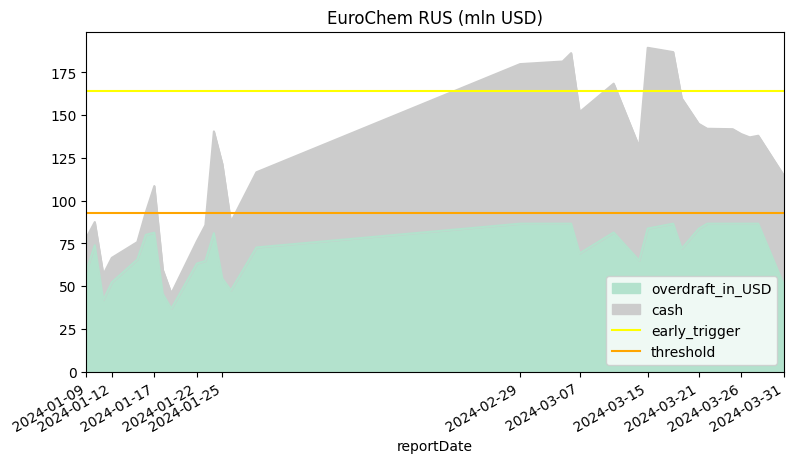

In [76]:
# for i in ['EUROCHEM', 'SUEK']:
#     data_plot = data_total.query("holding==@i")

#     ax = data_plot.plot(x='reportDate', y=['available_ovedraft', 'cash'], kind='area', stacked=True)

#     ax.axhline(y=data_plot.early_trigger[0], color='yellow', label='early_trigger')
#     ax.axhline(y=data_plot.threshold[0], color='orange', label='threshold')
#     handles, _ = ax.get_legend_handles_labels()
#     ax.legend(handles = handles[0:], labels=['overdraft_in_USD', 'cash','early_trigger', 'threshold'])

data_plot = data_total.query("holding=='EUROCHEM'")

xticks = data_plot.reportDate.tolist()[::3]

ax = data_plot.plot(x='reportDate', y=['available_ovedraft', 'cash'], kind='area', stacked=True, figsize=[9, 5], title='EuroChem RUS (mln USD)', colormap='Pastel2', xticks=xticks)

ax.axhline(y=data_plot.early_trigger.tolist()[0], color='yellow', label='early_trigger')
ax.axhline(y=data_plot.threshold.tolist()[0], color='orange', label='threshold')
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles = handles[0:], labels=['overdraft_in_USD', 'cash','early_trigger', 'threshold'])
start, end = data_plot.reportDate.min(), data_plot.reportDate.max()
ax.set_xlim([start, end])


plt.savefig('foo.png')


In [73]:
data_plot.early_trigger.tolist()[0]

251

Запись в файл:

In [260]:
TD = data_total.reportDate.dt.date.unique()[0]
TD_str = str(TD)
Output_file_ECH = "_".join([TD_str, 'Oper_liquidity_ECh.xlsx'])
Output_file_SUEK = "_".join([TD_str, 'Oper_liquidity_SUEK.xlsx'])

# data_total_ECH.to_excel(Output_file_ECH, index=False)

'2024-03-28_Oper_liquidity_ECh.xlsx'

Quality_ckeck.Missing_records

In [11]:
query = """
SELECT *
FROM "RISKACCESS"."bankAccountsBalanceDaily"
WHERE "reportDate" >= trunc(sysdate - interval '30' day)
ORDER BY "reportDate"
"""

data_QC_cash = export_from_RISKCUSTOM(query)

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


In [12]:
data_QC_cash['missing_record'] = data_QC_cash[['buCode', 'bankId', 'accountCurrency', 'accountNumber']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

last_date = data_QC_cash.reportDate.unique()[-1]
pre_last_date = data_QC_cash.reportDate.unique()[-2]
data_QC_cash_pre_last_date = data_QC_cash.loc[data_QC_cash.reportDate == pre_last_date, 'missing_record'].tolist()
data_QC_cash_last_date = data_QC_cash.loc[data_QC_cash.reportDate == last_date, 'missing_record'].tolist()

missing_records = [i for i in data_QC_cash_pre_last_date if i not in data_QC_cash_last_date]

data_missing_records = data_QC_cash[(data_QC_cash.missing_record.isin(missing_records)) & (data_QC_cash.reportDate == pre_last_date)]

Quality_ckeck.New_records

In [13]:
data_QC_cash_pre_last_date = data_QC_cash.loc[data_QC_cash.reportDate != last_date, 'missing_record'].tolist()
data_QC_cash_last_date = data_QC_cash.loc[data_QC_cash.reportDate == last_date, 'missing_record'].tolist()

new_records = [i for i in data_QC_cash_last_date if i not in data_QC_cash_pre_last_date]

data_new_records = data_QC_cash[(data_QC_cash.missing_record.isin(new_records)) & (data_QC_cash.reportDate == last_date)]

Quality_ckeck.Mapping

In [14]:
data_QC_cash['Map_holding'] = merge_SalesUnits(data_QC_cash, col='buCode', merge_col='holding')
data_QC_cash['Map_holding_2'] = merge_SalesUnits(data_QC_cash, col='buCode', id_col='oebs12ShortCode', merge_col='holding')
data_QC_cash.loc[data_QC_cash.Map_holding_2 == 'External' ,'Map_holding_2'] = data_QC_cash.loc[data_QC_cash.Map_holding_2 == 'External' ,'Map_holding']
data_map_holding = data_QC_cash.loc[(data_QC_cash.Map_holding_2 != data_QC_cash.holding) & (data_QC_cash.reportDate == data_QC_cash.reportDate.max()), ['buCode', 'holding', 'Map_holding_2']].drop_duplicates()
data_map_holding

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


,buCode,holding,Map_holding_2
65039,RUBGG,EUROCHEM,SUEK
67105,AEMNG,EUROCHEM,External


In [15]:
Output_file = str(last_date)[:10] + '_Oper_liquidity_QC.xlsx'
data_missing_records.to_excel(Output_file, sheet_name='Пропавшие_счета')
new_list(data_new_records, Output_file, sheet_name='Новые_счета', index=True)
new_list(data_map_holding, Output_file, sheet_name='Поиск_в_SalesUnits')